In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import numpy as np
from data import clean_and_split_nba_data as clean
from data import split_data as split
from data import resample_nba_data as re
from models import plot_validation_curve as vc
from models import eval_model as evm
import xgboost as xgb
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin
%load_ext autoreload
%autoreload 2

In [2]:
df = pd.read_csv("../data/raw/train.csv")
df

,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,10556,3799,80,24.3,7.8,3.0,6.4,45.7,0.1,0.3,...,2.9,72.1,2.2,2.0,3.8,3.2,1.1,0.2,1.6,1
1,5342,3800,75,21.8,10.5,4.2,7.9,55.1,-0.3,-1.0,...,3.6,67.8,3.6,3.7,6.6,0.7,0.5,0.6,1.4,1
2,5716,3801,85,19.1,4.5,1.9,4.5,42.8,0.4,1.2,...,0.6,75.7,0.6,1.8,2.4,0.8,0.4,0.2,0.6,1
3,13790,3802,63,19.1,8.2,3.5,6.7,52.5,0.3,0.8,...,1.5,66.9,0.8,2.0,3.0,1.8,0.4,0.1,1.9,1
4,5470,3803,63,17.8,3.7,1.7,3.4,50.8,0.5,1.4,...,0.5,54.0,2.4,2.7,4.9,0.4,0.4,0.6,0.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,2996,11794,32,9.2,1.8,0.7,1.8,40.3,-0.1,-0.2,...,0.6,65.7,0.3,1.8,1.9,0.5,0.3,0.2,0.4,1
7996,11679,11795,54,6.0,1.8,0.7,1.4,48.7,0.1,0.1,...,0.4,70.1,1.0,1.1,2.0,0.1,0.0,0.3,0.3,1
7997,5537,11796,85,28.2,10.7,4.0,9.0,45.1,0.2,0.6,...,3.9,69.7,1.0,2.1,3.1,3.4,1.2,0.2,1.8,1
7998,1292,11797,39,7.7,2.5,1.0,2.3,40.1,-0.3,-0.5,...,0.7,74.3,0.4,0.6,0.9,0.2,0.3,0.3,0.5,1


In [8]:
df_upsampled, df_downsampled = re.resample_nba_data(df)

df_minority.shape (1331, 22)  df_majority.shape (6669, 22)
df_minority.shape 0    1331
Name: TARGET_5Yrs, dtype: int64  df_majority.shape 1    6669
Name: TARGET_5Yrs, dtype: int64
df_upsampled  0    6669
1    6669
Name: TARGET_5Yrs, dtype: int64
0    6669
1    6669
Name: TARGET_5Yrs, dtype: int64
df_downsampled  0    1331
1    1331
Name: TARGET_5Yrs, dtype: int64
0    1331
1    1331
Name: TARGET_5Yrs, dtype: int64


In [9]:
df_upsampled.shape,df_downsampled.shape

((13338, 22), (2662, 22))

In [10]:
df_upsampled

,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,10556,3799,80,24.3,7.8,3.0,6.4,45.7,0.1,0.3,...,2.9,72.1,2.2,2.0,3.8,3.2,1.1,0.2,1.6,1
1,5342,3800,75,21.8,10.5,4.2,7.9,55.1,-0.3,-1.0,...,3.6,67.8,3.6,3.7,6.6,0.7,0.5,0.6,1.4,1
2,5716,3801,85,19.1,4.5,1.9,4.5,42.8,0.4,1.2,...,0.6,75.7,0.6,1.8,2.4,0.8,0.4,0.2,0.6,1
3,13790,3802,63,19.1,8.2,3.5,6.7,52.5,0.3,0.8,...,1.5,66.9,0.8,2.0,3.0,1.8,0.4,0.1,1.9,1
4,5470,3803,63,17.8,3.7,1.7,3.4,50.8,0.5,1.4,...,0.5,54.0,2.4,2.7,4.9,0.4,0.4,0.6,0.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13333,6126,10647,68,23.5,13.0,5.4,9.9,55.3,0.1,0.1,...,3.0,69.0,2.4,2.6,4.9,1.3,0.7,0.3,1.8,0
13334,7088,4573,39,6.7,2.1,0.7,1.7,40.9,0.4,1.0,...,0.7,79.6,0.8,0.6,1.3,0.0,0.1,0.2,0.3,0
13335,5022,11201,63,11.0,5.7,2.3,5.4,42.0,-0.1,-0.2,...,1.9,71.5,1.5,1.3,2.5,1.3,0.4,0.2,0.9,0
13336,1373,9473,64,16.7,5.5,2.4,4.4,54.2,0.0,0.0,...,1.0,72.3,1.5,1.7,3.2,0.5,0.5,0.3,0.9,0


In [11]:
x_data, x_train, x_val, x_test, y_data , y_train, y_val,  y_test = clean.clean_and_split_nba_data(df_upsampled)

Index(['GP', 'MIN', 'PTS', 'FGM', 'FGA', '3P Made', '3PA', 'FTM', 'FTA',
       'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'CALC3P%', 'CALCFG%',
       'CALCFT%'],
      dtype='object')


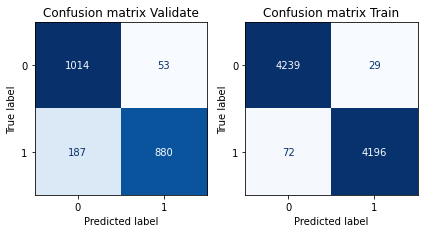

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=8, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=1)


(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
               gamma=0, gpu_id=-1, importance_type='gain',
               interaction_constraints='', learning_rate=0.300000012,
               max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=100, n_jobs=8,
               num_parallel_tree=1, random_state=8, reg_alpha=0, reg_lambda=1,
               scale_pos_weight=1, subsample=1, tree_method='exact',
               use_label_encoder=False, validate_parameters=1, verbosity=1),
 0.9990008686952618,
 0.9487092101899974)

In [12]:
evm.eval_model(xgb.XGBClassifier(random_state=8, verbosity=1,
                                 use_label_encoder=False,
                                 objective ='binary:logistic',
                                 eval_metric='auc'),x_train,y_train,x_val,y_val)

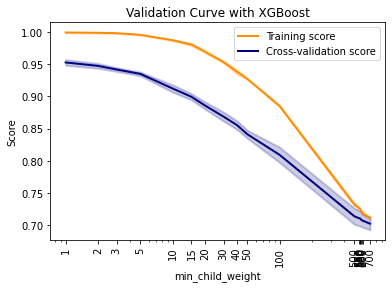

In [13]:
vc.plot_validation_curve(estimator=xgb.XGBClassifier(random_state=8, 
                                                     verbosity=1,
                                                     use_label_encoder=False,
                                                     objective ='binary:logistic',
                                                     eval_metric='auc'
                                                    ),
                    hyperparameter='min_child_weight',
                    hyperparameter_value=[1,2,3,5,10,15,20,30,40,50,100,500,550,560,570,580,590,600,700],
                    x=x_data,
                    y=y_data,
                    title="XGBoost",
                    cv=5)

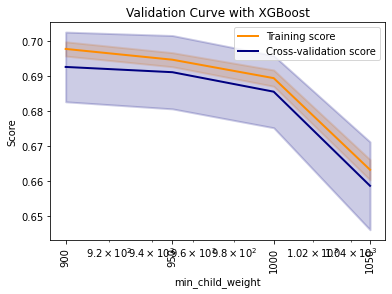

In [14]:
vc.plot_validation_curve(estimator=xgb.XGBClassifier(random_state=8, 
                                                     verbosity=1,
                                                     use_label_encoder=False,
                                                     objective ='binary:logistic',
                                                     eval_metric='auc'),
                    hyperparameter='min_child_weight',
                    hyperparameter_value=range(900,1100,50),
                    x=x_data,
                    y=y_data,
                    title="XGBoost",
                    cv=5)

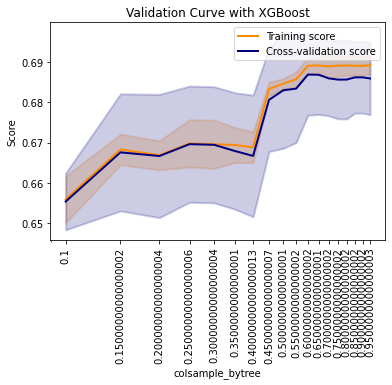

In [18]:
vc.plot_validation_curve(estimator=xgb.XGBClassifier(random_state=8, 
                                                     verbosity=1,
                                                     use_label_encoder=False,
                                                     objective ='binary:logistic',
                                                     eval_metric='auc'
                                                    ,min_child_weight=1000
                                                    
                                                    ),
                    hyperparameter='colsample_bytree',
                    hyperparameter_value=np.arange( 0.1, 1.0, 0.05),
                    x=x_data,
                    y=y_data,
                    title="XGBoost",
                    cv=5)

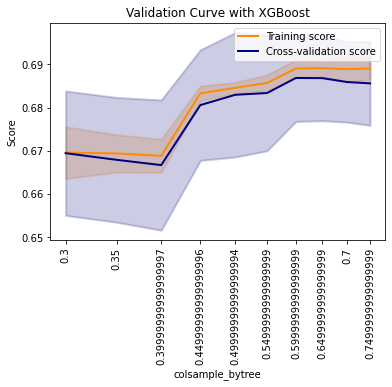

In [22]:
vc.plot_validation_curve(estimator=xgb.XGBClassifier(random_state=8, 
                                                     verbosity=1,
                                                     use_label_encoder=False,
                                                     objective ='binary:logistic',
                                                     eval_metric='auc'
                                                    ,min_child_weight=1000
                                                    
                                                    ),
                    hyperparameter='colsample_bytree',
                    hyperparameter_value=np.arange( 0.30, 0.80, 0.05),
                    x=x_data,
                    y=y_data,
                    title="XGBoost",
                    cv=5)

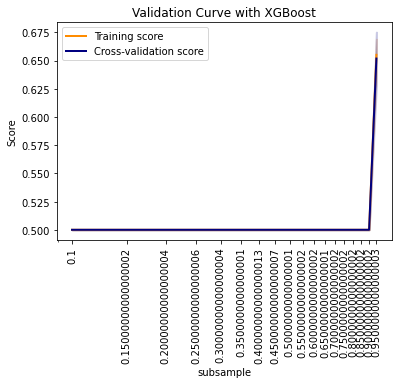

In [23]:
vc.plot_validation_curve(estimator=xgb.XGBClassifier(random_state=8, 
                                                     verbosity=1,
                                                     use_label_encoder=False,
                                                     objective ='binary:logistic',
                                                     eval_metric='auc',
                                                     min_child_weight=1000,
                                                     colsample_bytree=0.50
                                                    
                                                    ),
                    hyperparameter='subsample',
                    hyperparameter_value=np.arange( 0.1, 1.0, 0.05),
                    x=x_data,
                    y=y_data,
                    title="XGBoost",
                    cv=5)

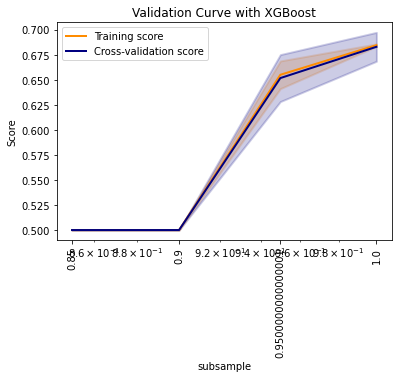

In [26]:
vc.plot_validation_curve(estimator=xgb.XGBClassifier(random_state=8, 
                                                     verbosity=1,
                                                     use_label_encoder=False,
                                                     objective ='binary:logistic',
                                                     eval_metric='auc',
                                                     min_child_weight=1000
                                                     ,colsample_bytree=0.50
                                                    
                                                    ),
                    hyperparameter='subsample',
                    hyperparameter_value=np.arange( 0.85, 1.0, 0.05),
                    x=x_data,
                    y=y_data,
                    title="XGBoost",
                    cv=5)

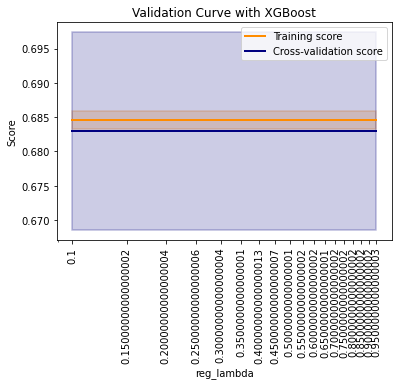

In [27]:
vc.plot_validation_curve(estimator=xgb.XGBClassifier(random_state=8, 
                                                     verbosity=1,
                                                     use_label_encoder=False,
                                                     objective ='binary:logistic',
                                                     eval_metric='auc'
                                                    ,min_child_weight=1000
                                                     ,colsample_bytree=0.50
                                                     ,subsample=1
                                                    ),
                    hyperparameter='reg_lambda',
                    hyperparameter_value=np.arange( 0.1, 1.0, 0.05),
                    x=x_data,
                    y=y_data,
                    title="XGBoost",
                    cv=5)

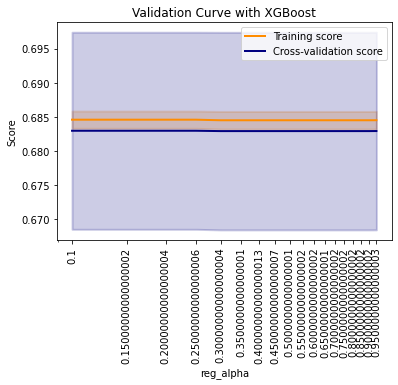

In [28]:
vc.plot_validation_curve(estimator=xgb.XGBClassifier(random_state=8, 
                                                     verbosity=1,
                                                     use_label_encoder=False,
                                                     objective ='binary:logistic',
                                                     eval_metric='auc'
                                                    ,min_child_weight=1000
                                                     ,colsample_bytree=0.50
                                                     ,subsample=1
                                                    ),
                    hyperparameter='reg_alpha',
                    hyperparameter_value=np.arange( 0.1, 1.0, 0.05),
                    x=x_data,
                    y=y_data,
                    title="XGBoost",
                    cv=5)

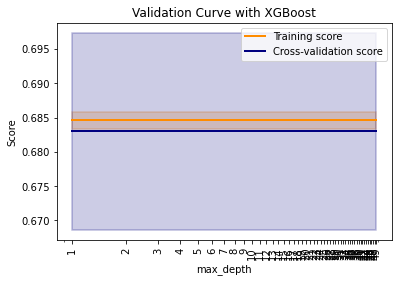

In [29]:
vc.plot_validation_curve(estimator=xgb.XGBClassifier(random_state=8, 
                                                     verbosity=1,
                                                     use_label_encoder=False,
                                                     objective ='binary:logistic',
                                                     eval_metric='auc',
                                                    min_child_weight=1000
                                                     ,colsample_bytree=0.50
                                                     ,subsample=1
                                                    
                                                    ),
                    hyperparameter='max_depth',
                    hyperparameter_value=range(1,50,1),
                    x=x_data,
                    y=y_data,
                    title="XGBoost",
                    cv=5)

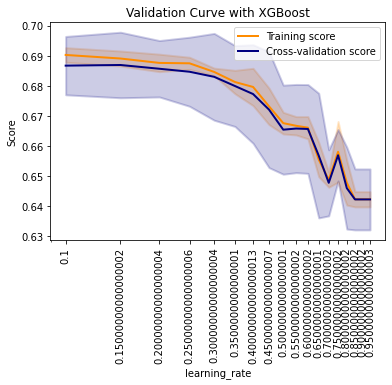

In [30]:
vc.plot_validation_curve(estimator=xgb.XGBClassifier(random_state=8, 
                                                     verbosity=1,
                                                     use_label_encoder=False,
                                                     objective ='binary:logistic',
                                                     eval_metric='auc',
                                                    min_child_weight=1000
                                                     ,colsample_bytree=0.50
                                                     ,subsample=1
                                                    
                                                    ),
                    hyperparameter='learning_rate',
                    hyperparameter_value=np.arange( 0.1, 1.0, 0.05),
                    x=x_data,
                    y=y_data,
                    title="XGBoost",
                    cv=5)

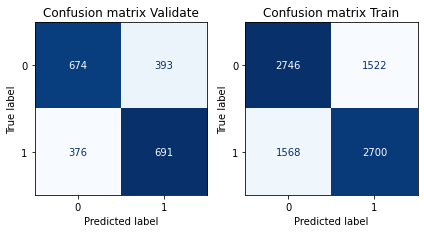

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=6, min_child_weight=1000, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=8, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=1)


(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.5, eval_metric='auc',
               gamma=0, gpu_id=-1, importance_type='gain',
               interaction_constraints='', learning_rate=0.2, max_delta_step=0,
               max_depth=6, min_child_weight=1000, missing=nan,
               monotone_constraints='()', n_estimators=100, n_jobs=8,
               num_parallel_tree=1, random_state=8, reg_alpha=0, reg_lambda=1,
               scale_pos_weight=1, subsample=1, tree_method='exact',
               use_label_encoder=False, validate_parameters=1, verbosity=1),
 0.6876296400316559,
 0.686239831917568)

In [38]:
xgboost1=xgb.XGBClassifier(random_state=8, 
                verbosity=1,
                use_label_encoder=False,
                objective ='binary:logistic',
                eval_metric='auc',
                min_child_weight=1000
                ,colsample_bytree=0.50
                ,subsample=1
                ,learning_rate=0.2)
evm.eval_model(xgboost1,x_train,y_train,x_val,y_val)

In [42]:
from sklearn.model_selection import cross_val_score
space = {
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.25, 0.001),
    'min_child_weight' : hp.quniform('min_child_weight', 900, 1100, 1),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.3, 0.8, 0.001),
    'subsample' : hp.quniform('subsample', 0.85, 1, 0.001)
}
space

{'learning_rate': <hyperopt.pyll.base.Apply at 0x175106ba0d0>,
 'min_child_weight': <hyperopt.pyll.base.Apply at 0x17510e6bcd0>,
 'colsample_bytree': <hyperopt.pyll.base.Apply at 0x175106c3e80>,
 'subsample': <hyperopt.pyll.base.Apply at 0x17510d060a0>}

In [43]:
def objective(space):
   
    xgboost = xgb.XGBClassifier(
        random_state=8,
        learning_rate = space['learning_rate'],
        min_child_weight = space['min_child_weight'],
        colsample_bytree = space['colsample_bytree'],
        subsample = space['subsample'],
        use_label_encoder=False,
        objective ='binary:logistic',
        eval_metric ='auc'
    )
    
    acc = cross_val_score(xgboost, x_train, y_train, cv=10,scoring='roc_auc').mean()

    return{'loss': 1-acc, 'status': STATUS_OK }
best = fmin(
    fn=objective,   
    space=space,       
    algo=tpe.suggest,       
    max_evals=5
)
print("Best: ", best)

100%|█████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.52s/trial, best loss: 0.5]
Best:  {'colsample_bytree': 0.756, 'learning_rate': 0.041, 'min_child_weight': 978.0, 'subsample': 0.855}


c:\users\xauspi\.virtualenvs\kaggle_assignment-dq2gjalz\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\xauspi\.virtualenvs\kaggle_assignment-dq2gjalz\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


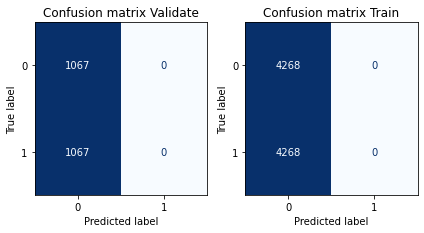

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.447, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.077, max_delta_step=0,
              max_depth=6, min_child_weight=1069, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=8, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.889, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=1)


(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.447, eval_metric='auc',
               gamma=0, gpu_id=-1, importance_type='gain',
               interaction_constraints='', learning_rate=0.077, max_delta_step=0,
               max_depth=6, min_child_weight=1069, missing=nan,
               monotone_constraints='()', n_estimators=100, n_jobs=8,
               num_parallel_tree=1, random_state=8, reg_alpha=0, reg_lambda=1,
               scale_pos_weight=1, subsample=0.889, tree_method='exact',
               use_label_encoder=False, validate_parameters=1, verbosity=1),
 0.5,
 0.5)

In [41]:
xgboos2=xgb.XGBClassifier(random_state=8, 
                verbosity=1,
                use_label_encoder=False,
                objective ='binary:logistic',
                eval_metric='auc',
                min_child_weight=1069
                ,colsample_bytree=0.447
                ,subsample=0.889
                ,learning_rate=0.077)
evm.eval_model(xgboos2,x_train,y_train,x_val,y_val)

(0.6774082973505751,
 0.6289355322338831,
 0.6227134146341464,
 0.6333333333333333,
 0.6124437781109445,
 0.6289355322338831)

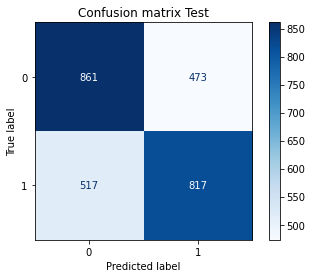

In [44]:
evm.get_performance(xgboost1, x_test, y_test, "Test", True)

In [45]:
from joblib import dump
dump(xgboost1,  '../models/sp_wk3_xgboost_upsample_model.joblib')

['../models/sp_wk3_xgboost_upsample_model.joblib']